In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
print(os.listdir("../content"))

Using TensorFlow backend.


['.config', 'facades', 'facades.zip', 'sample_data']


In [0]:
def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))
        print(path)
        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
        #normalizing the images
        imgs_A = np.array(imgs_A)/127.5 - 1.  
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [0]:
def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))

        
        n_batches=int(len(path)/batch_size)
        img_res=(128,128)
        for i in range(n_batches):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

**Generator**

In [0]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        # Image input
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)
       

**Discriminator**

In [0]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [6]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def show_images( dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
        
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

**Training GAN Conditionally**

In [0]:
def train( dataset_name,epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        losses=[]
        for epoch in range(1,epochs+1):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):
                #print(imgs_B)
        
                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
            
            # Plot the progress
            if epoch%show_interval==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,d_loss[0], 100*d_loss[1],g_loss[0],elapsed_time))
                  losses.append((d_loss[0],g_loss))      
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)
                
        return losses

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 50/500]  [D loss: 0.116991, acc:  86%] [G loss: 18.379894] time: 0:09:56.070577
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val/

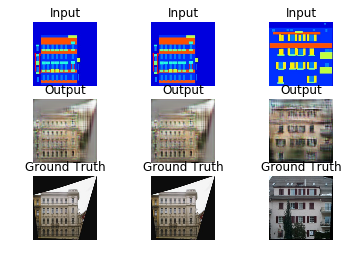

[Epoch 100/500]  [D loss: 0.114867, acc:  87%] [G loss: 14.681829] time: 0:19:39.229486
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val

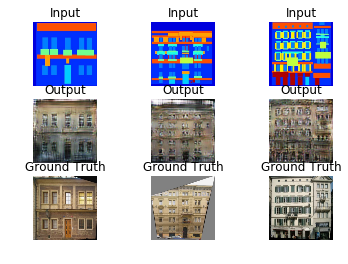

[Epoch 150/500]  [D loss: 0.174171, acc:  74%] [G loss: 12.838864] time: 0:29:24.681304
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val

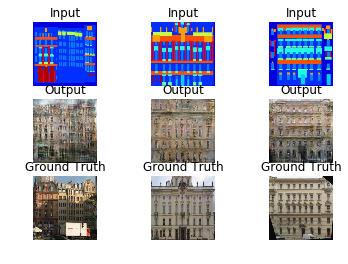

[Epoch 200/500]  [D loss: 0.157113, acc:  79%] [G loss: 11.307913] time: 0:39:09.973407
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val

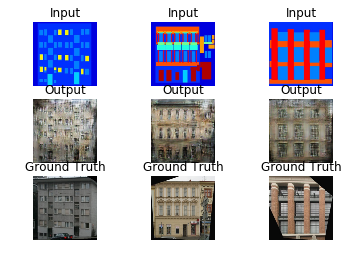

[Epoch 250/500]  [D loss: 0.093471, acc:  92%] [G loss: 10.513531] time: 0:48:55.030069
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val

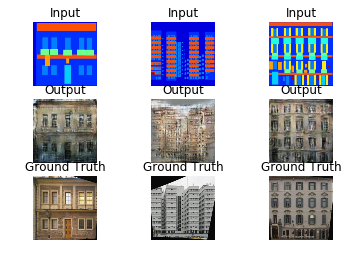

[Epoch 300/500]  [D loss: 0.268334, acc:  61%] [G loss: 10.310944] time: 0:58:40.130220
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val

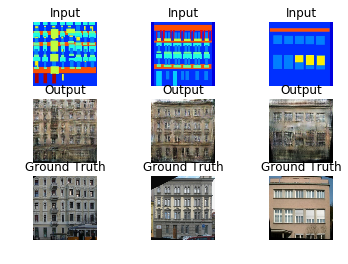

[Epoch 350/500]  [D loss: 0.275896, acc:  45%] [G loss: 7.917091] time: 1:08:24.804293
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val/

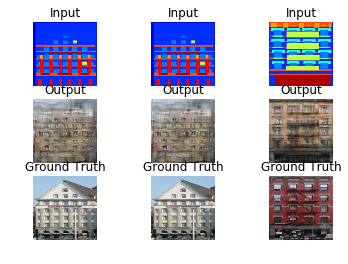

[Epoch 400/500]  [D loss: 0.274684, acc:  42%] [G loss: 7.295299] time: 1:18:08.827587
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val/

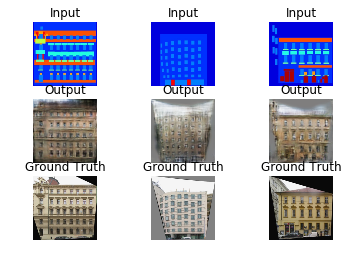

[Epoch 450/500]  [D loss: 0.272377, acc:  44%] [G loss: 7.193329] time: 1:27:49.468378
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val/

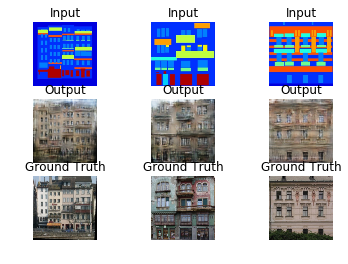

[Epoch 500/500]  [D loss: 0.271713, acc:  43%] [G loss: 6.790556] time: 1:37:30.762398
['../content/facades/val/84.jpg', '../content/facades/val/4.jpg', '../content/facades/val/77.jpg', '../content/facades/val/7.jpg', '../content/facades/val/63.jpg', '../content/facades/val/20.jpg', '../content/facades/val/30.jpg', '../content/facades/val/14.jpg', '../content/facades/val/17.jpg', '../content/facades/val/26.jpg', '../content/facades/val/88.jpg', '../content/facades/val/25.jpg', '../content/facades/val/99.jpg', '../content/facades/val/61.jpg', '../content/facades/val/22.jpg', '../content/facades/val/40.jpg', '../content/facades/val/19.jpg', '../content/facades/val/86.jpg', '../content/facades/val/65.jpg', '../content/facades/val/9.jpg', '../content/facades/val/85.jpg', '../content/facades/val/13.jpg', '../content/facades/val/60.jpg', '../content/facades/val/12.jpg', '../content/facades/val/49.jpg', '../content/facades/val/28.jpg', '../content/facades/val/52.jpg', '../content/facades/val/

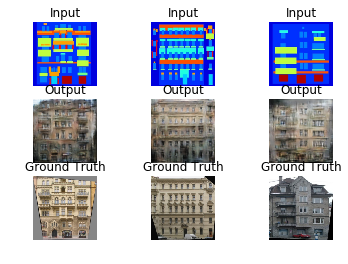

In [9]:
losses = train("facades",epochs=500, batch_size=32, show_interval=50)


In [0]:
def show_losses(losses, i):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1][i], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

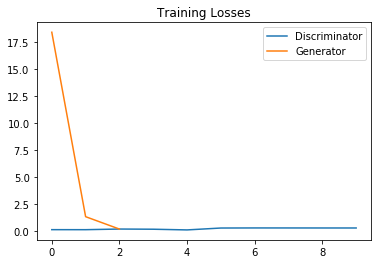

In [16]:
show_losses(losses, 0)

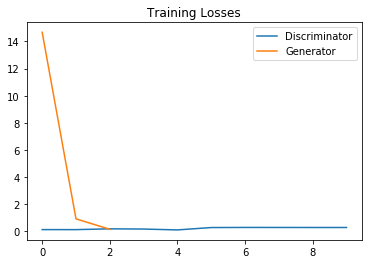

In [17]:
show_losses(losses, 1)

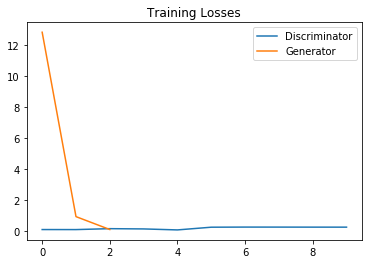

In [18]:
show_losses(losses, 2)

In [19]:
print(losses)

[(0.11699101, [18.379894, 1.3179425, 0.17061952]), (0.1148674, [14.681829, 0.90940887, 0.1377242]), (0.17417055, [12.838864, 0.950532, 0.11888333]), (0.15711284, [11.307913, 0.7624825, 0.1054543]), (0.093470566, [10.513531, 0.8483839, 0.09665147]), (0.26833367, [10.310944, 0.97161615, 0.09339328]), (0.27589563, [7.917091, 0.286809, 0.07630282]), (0.27468443, [7.2952986, 0.27241868, 0.0702288]), (0.27237716, [7.193329, 0.27403134, 0.069192976]), (0.2717135, [6.790556, 0.28728783, 0.06503268])]
